In [1]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=036f2c7753841cba947b1c1a7549ba0e96de40561e61c04809a934e0788f8609
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=180771 sha256=0e33ea578af2ecf872437be48e51c95bdea6448c9d2f8661ce995aeee38a98cf
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting unin

In [ ]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 55.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.7 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/Mahbub-Mt/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [47]:
import pandas as pd
import numpy as np
import hazm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix,ConfusionMatrixDisplay



from transformers import BertConfig, BertTokenizer
from transformers import BertModel


import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.layers import Input, Dense, Dropout, Softmax
from keras.models import Model

In [5]:
#process all files and find datas with reasonable size and also try to overcome imbalanced dataset
poets = []
min_poem_count = 15000
datapath = '/content/Persian_poems_corpus/normalized/'
normalizer = hazm.Normalizer()
for poet_file in sorted(os.listdir(datapath)):
  df= pd.read_csv(datapath+poet_file,skip_blank_lines=True,header=None,encoding='utf-8')
  df.columns = ["half-verse"]
  df['idx'] = df.index
  df['idx'] = df['idx']//2
  df['half-verse'] = df['half-verse'].apply(lambda t: normalizer.normalize(t))
  df['verse'] = df.groupby(['idx'])['half-verse'].transform(lambda x : ' '.join(x))
  df.drop(['half-verse','idx'], axis=1, inplace=True)
  df.drop_duplicates(inplace=True)
  df.reset_index(drop=True, inplace=True)
  poem_count = df.shape[0]
  if poem_count > 9000 and poem_count < 15000 :
    if poem_count < min_poem_count:
      min_poem_count = poem_count

    print(f'Poet: {poet_file[:-9]} \tPoem Count: {poem_count}')
    poets.append(poet_file[:-9])

len(poets) , min_poem_count

Poet: anvari 	Poem Count: 13246
Poet: farrokhi 	Poem Count: 11525
Poet: feyz 	Poem Count: 9840
Poet: naserkhosro 	Poem Count: 10749
Poet: nezari 	Poem Count: 10228
Poet: ouhadi 	Poem Count: 14595
Poet: salman 	Poem Count: 12948
Poet: seyf 	Poem Count: 12000
Poet: shahnematollah 	Poem Count: 14764
Poet: vahshi 	Poem Count: 10485


(10, 9840)

In [6]:
max_verse_len = 0
df_list = []
for i,poet in enumerate(poets) :
  df= pd.read_csv(datapath+poet+'_norm.txt',skip_blank_lines=True,header=None,encoding='utf-8')
  df.columns = ["half-verse"]
  df['idx'] = df.index
  df['idx'] = df['idx']//2
  df['half-verse'] = df['half-verse'].apply(lambda t: normalizer.normalize(t))
  df['verse'] = df.groupby(['idx'])['half-verse'].transform(lambda x : ' '.join(x))
  df.drop(['half-verse','idx'], axis=1, inplace=True)
  df.drop_duplicates(inplace=True)
  df.reset_index(drop=True, inplace=True)
  df['label'] = i
  df['len'] = df['verse'].apply(lambda t: len(hazm.word_tokenize(t)))
  if df.shape[0] != min_poem_count: #downsample to get balanced data
    df = df.sample(n= min_poem_count+(df.shape[0]-min_poem_count)//2 , random_state=42).reset_index(drop=True)

  min_verse, max_verse = df['len'].min(), df['len'].max()
  if max_verse_len < df['len'].max():
    max_verse_len = df['len'].max()
  print(f'Poet: {poet} \tMin: {min_verse} \tMax: {max_verse} \tPoem Count: {df.shape[0]}')

  df_list.append(df)

print(f'Maximum verse Length: {max_verse_len}\n')
df_final = pd.concat(df_list, axis=0)
df_final.drop(['len'], axis=1, inplace=True)
df_final = df_final.sample(frac=1,random_state=42).reset_index(drop=True)
df_final.head(10)

Poet: anvari 	Min: 6 	Max: 25 	Poem Count: 11543
Poet: farrokhi 	Min: 7 	Max: 26 	Poem Count: 10682
Poet: feyz 	Min: 4 	Max: 25 	Poem Count: 9840
Poet: naserkhosro 	Min: 4 	Max: 26 	Poem Count: 10294
Poet: nezari 	Min: 6 	Max: 25 	Poem Count: 10034
Poet: ouhadi 	Min: 6 	Max: 25 	Poem Count: 12217
Poet: salman 	Min: 6 	Max: 27 	Poem Count: 11394
Poet: seyf 	Min: 7 	Max: 24 	Poem Count: 10920
Poet: shahnematollah 	Min: 6 	Max: 24 	Poem Count: 12302
Poet: vahshi 	Min: 6 	Max: 23 	Poem Count: 10162
Maximum verse Length: 27



,verse,label
0,در بوستان به یاد دهن تو غنچه را هر دم هزار بوس...,6
1,ما در آنیم تا قضا و قدر زهر آن فتنه باز قند کنند,0
2,دانی چه قیاس راست بشنو بر خود چه کتاب عشوه خوانی,0
3,زاهدی‌گر گویدت از باده نوشی توبه کن جرعه‌ای در...,8
4,دربند دمی که بی غمی باشم بنگر که چه انتظار می‌...,0
5,خیز و آیینه از مردم بینا بطلب بنشین در نظر ما ...,8
6,مستی و عشق از ازل پیشه و آیین ماست دین من این ...,6
7,هر که بر او سایه فکند آن درخت رست ز تیمار و ز ...,1
8,فتادی همچو گل از دست بر دست که شد در خواب نازش...,9
9,باز اگر تو فقع خوری به مثل چوبک کوزه فقع بمکی,0


In [ ]:
print(df_final.isnull().sum(), '\n')

verse    0
label    0
dtype: int64 



In [ ]:
df_final['label'].value_counts()

8    12302
5    12217
0    11543
6    11394
7    10920
1    10682
3    10294
9    10162
4    10034
2     9840
Name: label, dtype: int64

In [7]:
# general config
MAX_LEN = 30
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
bert = TFBertModel.from_pretrained(MODEL_NAME_OR_PATH)

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:


train, test = train_test_split(df_final, test_size=0.1, random_state=42, stratify=df_final['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=42, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)




y_train = to_categorical(train.label)
y_valid = to_categorical(valid.label)
y_test = to_categorical(test.label)

x_train = tokenizer(
                    text= train.verse.tolist(),
                    add_special_tokens=True,
                    max_length=MAX_LEN,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)

x_valid = tokenizer(
                    text= valid.verse.tolist(),
                    add_special_tokens=True,
                    max_length=MAX_LEN,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)
x_test = tokenizer(
                    text= test.verse.tolist(),
                    add_special_tokens=True,
                    max_length=MAX_LEN,
                    truncation=True,
                    padding='max_length', 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True)


train.shape,valid.shape,test.shape

((88604, 2), (9845, 2), (10939, 2))

## الف)

In [10]:
def build_model(bert, max_len, is_trainable, optimizer):
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    
    outputs = bert(input_ids,attention_mask = input_mask)
    net = outputs['pooler_output']
    
    net = Dropout(0.1)(net)
    net = Dense(10, activation=None)(net)
    
    model = Model(inputs=[input_ids, input_mask], outputs=net)
    model.layers[2].trainable = is_trainable


    model.compile(optimizer=optimizer, loss =CategoricalCrossentropy(from_logits = True),metrics = CategoricalAccuracy('balanced_accuracy'))
    
    return model

In [ ]:

model = build_model(bert,30,False,Adam(learning_rate=5e-04,epsilon=1e-07))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = ({'input_ids':x_valid['input_ids'],'attention_mask':x_valid['attention_mask']}, y_valid),
    epochs=3,
    batch_size=32
)

Epoch 1/3
2769/2769 [==============================] - 260s 88ms/step - loss: 2.1502 - balanced_accuracy: 0.2195 - val_loss: 2.0158 - val_balanced_accuracy: 0.2857
Epoch 2/3
2769/2769 [==============================] - 238s 86ms/step - loss: 2.0577 - balanced_accuracy: 0.2660 - val_loss: 1.9810 - val_balanced_accuracy: 0.3001
Epoch 3/3
2769/2769 [==============================] - 259s 94ms/step - loss: 2.0294 - balanced_accuracy: 0.2785 - val_loss: 1.9642 - val_balanced_accuracy: 0.3087


In [ ]:
train_history.history.keys()

dict_keys(['loss', 'balanced_accuracy', 'val_loss', 'val_balanced_accuracy'])

In [14]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['balanced_accuracy']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['balanced_accuracy']
  val_acc = history_dict['val_balanced_accuracy']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

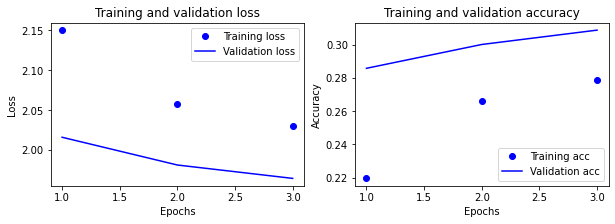

342/342 [==============================] - 26s 75ms/step - loss: 1.9477 - balanced_accuracy: 0.3235
Test loss: 1.9476832151412964
Test accuracy: 0.32352134585380554


In [ ]:
visualize_loss_and_acc(train_history)
loss, accuracy =  model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
y_logits = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},verbose=1)
y_pred = np.argmax(y_logits, axis = 1)
print('micro f1 score on test data:', f1_score(test['label'], y_pred, average='micro'))
print()
print('Classification Report')
print()
print(classification_report(test['label'], y_pred, target_names=poets))

342/342 [==============================] - 35s 80ms/step
micro f1 score on test data: 0.32352134564402596

Classification Report

                precision    recall  f1-score   support

        anvari       0.39      0.15      0.22      1154
      farrokhi       0.43      0.32      0.37      1068
          feyz       0.34      0.28      0.30       984
   naserkhosro       0.40      0.43      0.42      1030
        nezari       0.43      0.09      0.14      1003
        ouhadi       0.22      0.44      0.29      1222
        salman       0.30      0.29      0.29      1140
          seyf       0.34      0.33      0.34      1092
shahnematollah       0.49      0.52      0.51      1230
        vahshi       0.22      0.35      0.27      1016

      accuracy                           0.32     10939
     macro avg       0.35      0.32      0.31     10939
  weighted avg       0.35      0.32      0.32     10939



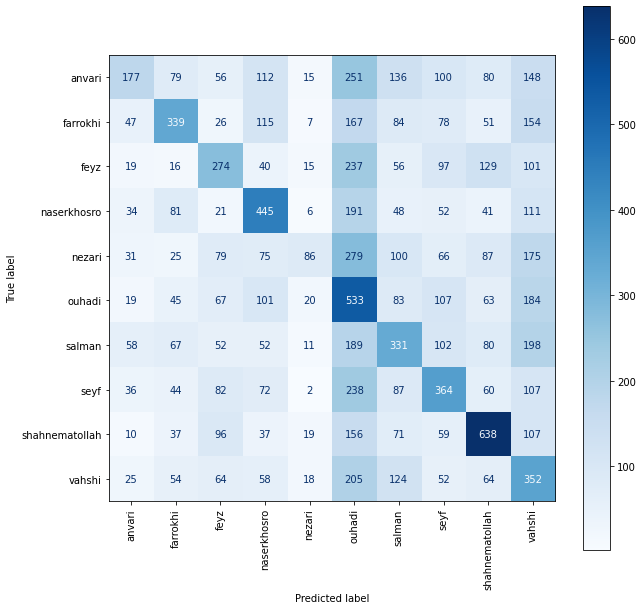

In [ ]:
cm = confusion_matrix(test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=poets)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax,xticks_rotation='vertical')
plt.show()

## ب)

### ADAM:

In [ ]:
model1 = build_model(bert, 30,True,Adam(learning_rate=5e-05,epsilon=1e-08))

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                          

In [ ]:
train_history1 = model1.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = ({'input_ids':x_valid['input_ids'],'attention_mask':x_valid['attention_mask']}, y_valid),
    epochs=2,
    batch_size=32
)

Epoch 1/2
2769/2769 [==============================] - 725s 256ms/step - loss: 1.3808 - balanced_accuracy: 0.5244 - val_loss: 1.0445 - val_balanced_accuracy: 0.6425
Epoch 2/2
2769/2769 [==============================] - 683s 247ms/step - loss: 0.8206 - balanced_accuracy: 0.7258 - val_loss: 0.9593 - val_balanced_accuracy: 0.6821


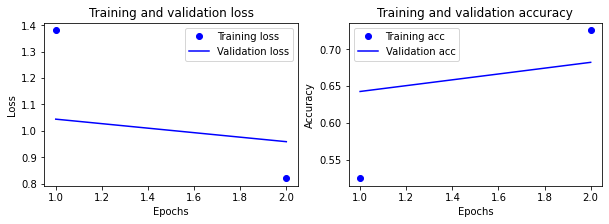

342/342 [==============================] - 27s 79ms/step - loss: 0.9334 - balanced_accuracy: 0.6891
Test loss: 0.9333817958831787
Test accuracy: 0.689094066619873


In [ ]:
visualize_loss_and_acc(train_history1)
loss, accuracy =  model1.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
y_logits = model1.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},verbose=1)
y_pred = np.argmax(y_logits, axis = 1)
print('micro f1 score on test data:', f1_score(test['label'], y_pred, average='micro'))
print()
print('Classification Report')
print()
print(classification_report(test['label'], y_pred, target_names=poets))

342/342 [==============================] - 29s 78ms/step
micro f1 score on test data: 0.6890940670993693

Classification Report

                precision    recall  f1-score   support

        anvari       0.58      0.60      0.59      1154
      farrokhi       0.82      0.74      0.78      1068
          feyz       0.70      0.76      0.73       984
   naserkhosro       0.77      0.84      0.81      1030
        nezari       0.64      0.67      0.66      1003
        ouhadi       0.54      0.70      0.61      1222
        salman       0.61      0.54      0.57      1140
          seyf       0.73      0.72      0.73      1092
shahnematollah       0.83      0.82      0.83      1230
        vahshi       0.72      0.50      0.59      1016

      accuracy                           0.69     10939
     macro avg       0.70      0.69      0.69     10939
  weighted avg       0.69      0.69      0.69     10939



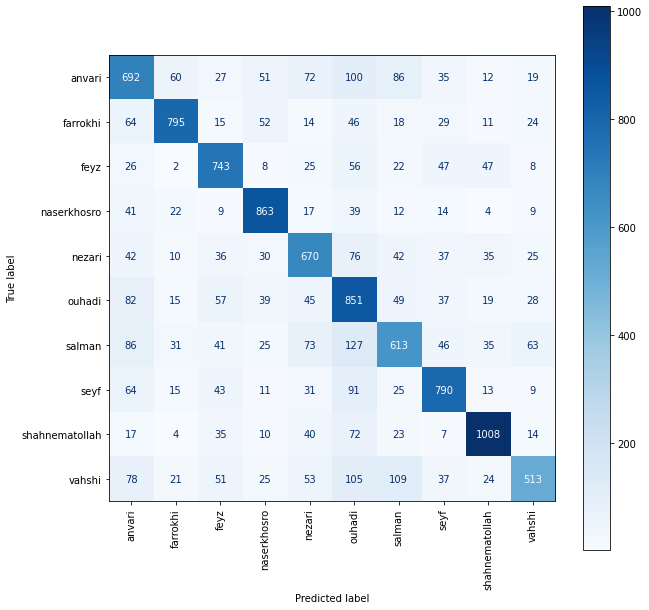

In [ ]:
cm = confusion_matrix(test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=poets)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax,xticks_rotation='vertical')
plt.show()

### SGD:

In [11]:
bert2 = TFBertModel.from_pretrained(MODEL_NAME_OR_PATH)
model2 = build_model(bert2, 30,True,SGD(learning_rate=5e-04,momentum=0.9))

model2.summary()

Some layers from the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [12]:
train_history2 = model2.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = ({'input_ids':x_valid['input_ids'],'attention_mask':x_valid['attention_mask']}, y_valid),
    epochs=4,
    batch_size=32
)

Epoch 1/4
2769/2769 [==============================] - 585s 206ms/step - loss: 1.7628 - balanced_accuracy: 0.3787 - val_loss: 1.5948 - val_balanced_accuracy: 0.4552
Epoch 2/4
2769/2769 [==============================] - 567s 205ms/step - loss: 1.3522 - balanced_accuracy: 0.5330 - val_loss: 1.3463 - val_balanced_accuracy: 0.5449
Epoch 3/4
2769/2769 [==============================] - 566s 205ms/step - loss: 1.1477 - balanced_accuracy: 0.6042 - val_loss: 1.1670 - val_balanced_accuracy: 0.5989
Epoch 4/4
2769/2769 [==============================] - 567s 205ms/step - loss: 0.9854 - balanced_accuracy: 0.6620 - val_loss: 1.0609 - val_balanced_accuracy: 0.6380


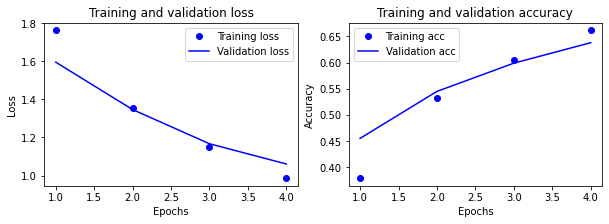

342/342 [==============================] - 26s 77ms/step - loss: 1.0300 - balanced_accuracy: 0.6507
Test loss: 1.0299506187438965
Test accuracy: 0.6506993174552917


In [16]:
visualize_loss_and_acc(train_history2)
loss, accuracy =  model2.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

model is not overfit (compared to fast overfitting with ADAM) and the test loss and accuracy are near Adam values

In [17]:
y_logits = model2.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']},verbose=1)
y_pred = np.argmax(y_logits, axis = 1)
print('micro f1 score on test data:', f1_score(test['label'], y_pred, average='micro'))
print()
print('Classification Report')
print()
print(classification_report(test['label'], y_pred, target_names=poets))

342/342 [==============================] - 30s 74ms/step
micro f1 score on test data: 0.6506993326629491

Classification Report

                precision    recall  f1-score   support

        anvari       0.63      0.50      0.56      1154
      farrokhi       0.83      0.63      0.72      1068
          feyz       0.67      0.69      0.68       984
   naserkhosro       0.75      0.79      0.77      1030
        nezari       0.65      0.57      0.61      1003
        ouhadi       0.48      0.64      0.55      1222
        salman       0.57      0.50      0.53      1140
          seyf       0.63      0.78      0.70      1092
shahnematollah       0.81      0.83      0.82      1230
        vahshi       0.59      0.56      0.58      1016

      accuracy                           0.65     10939
     macro avg       0.66      0.65      0.65     10939
  weighted avg       0.66      0.65      0.65     10939



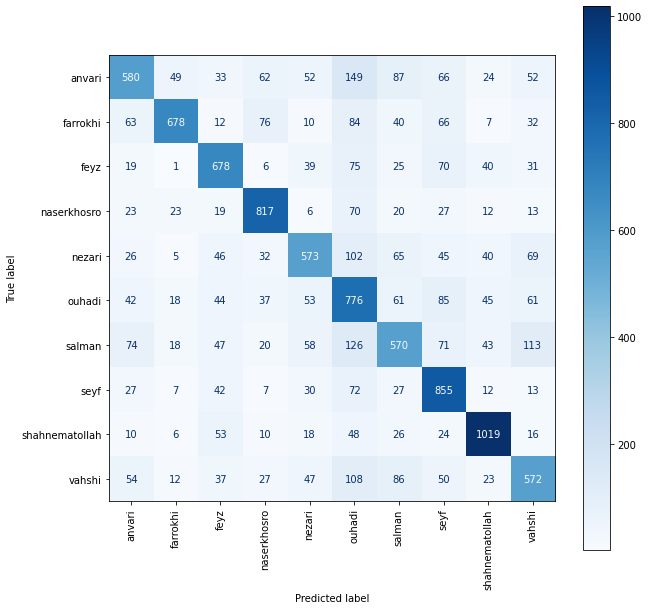

In [18]:
cm = confusion_matrix(test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=poets)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax,xticks_rotation='vertical')
plt.show()

## ج)

In [19]:
df_test = df_final.sample(n= 1000 , random_state=42).reset_index(drop=True)
df_test.head()

,verse,label
0,بنده سید سرمستانم پیش رندان جهان معتبرم,8
1,از پی پوشش تو شد کرده چون تو از پرده روی باز کنی,5
2,گهی مانده ز آوردن کرگدن جهان را همه ساله اندیش...,1
3,چو دستار ریاست بر سر تست ترا این طوق در گردن ن...,7
4,برده رضوان ز بهشت از پی پیوندگری از تو هر فضله...,0


In [20]:
y = to_categorical(df_test.label)

x = tokenizer(
              text= df_test.verse.tolist(),
              add_special_tokens=True,
              max_length=MAX_LEN,
              truncation=True,
              padding='max_length', 
              return_tensors='tf',
              return_token_type_ids = False,
              return_attention_mask = True,
              verbose = True)

In [21]:
!pip install keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 38.9 MB/s eta 0:00:00


In [22]:
from keras_nlp.metrics import Perplexity

### الف:

In [ ]:
y_logits = model.predict({'input_ids':x['input_ids'],'attention_mask':x['attention_mask']},verbose=1)

32/32 [==============================] - 3s 83ms/step


In [ ]:
perplexity = Perplexity(mask_token_id=0,from_logits=True)
perplexity(df_test['label'].squeeze(),y_logits)

<tf.Tensor: shape=(), dtype=float32, numpy=7.2502565>

### ب:

In [23]:
y_logits = model2.predict({'input_ids':x['input_ids'],'attention_mask':x['attention_mask']},verbose=1)

32/32 [==============================] - 3s 90ms/step


In [27]:
perplexity = Perplexity(mask_token_id=0,from_logits=True, name='perplexity')
perplexity(df_test['label'].squeeze(),y_logits)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1054344>

I also checked with the original expression:

In [30]:
import keras.backend as K

In [42]:
y_pred = np.argmax(y_logits, axis = 1)

In [52]:
layer = Softmax()
y_prob = layer(y_logits).numpy()

In [53]:
K.exp(K.mean(K.categorical_crossentropy(y, y_prob)))

<tf.Tensor: shape=(), dtype=float32, numpy=2.2224948>

as it was mentioned in https://towardsdatascience.com/perplexity-in-language-models-87a196019a94 , a lower perplexity means the model is less surprised to see test data. our model reached better results after training the whole model so perplexity lessened